In [25]:
import os
import cv2
import json
import base64
import zlib
import numpy as np
from tqdm import tqdm
import logging
from pathlib import Path

# ---------------- LOGGING SETUP ---------------- #
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

logger = logging.getLogger()
logger.info("Logging initialized successfully.")

2026-02-15 12:11:41,724 - INFO - Logging initialized successfully.


In [26]:
# ---------------- PATH CONFIG ---------------- #

RAW_DIR = Path("../data/raw")
MERGED_IMG_DIR = Path("../data/merged/images")
MERGED_MASK_DIR = Path("../data/merged/masks")

MERGED_IMG_DIR.mkdir(parents=True, exist_ok=True)
MERGED_MASK_DIR.mkdir(parents=True, exist_ok=True)

logger.info("Directory structure verified.")

2026-02-15 12:11:41,739 - INFO - Directory structure verified.


In [27]:
HRF_DIR = Path("../data/raw/hrf")
HRF_IMG_DIR = os.path.join(HRF_DIR, "images")
HRF_GT_DIR = os.path.join(HRF_DIR, "manual1")

In [28]:
drive_path = RAW_DIR / "drive"

print("RAW_DIR:", RAW_DIR.resolve())
print("Drive path exists:", drive_path.exists())

print("Training images path:", (drive_path / "training/images").resolve())
print("Exists:", (drive_path / "training/images").exists())

print("Files inside training/images:")
if (drive_path / "training/images").exists():
    print(list((drive_path / "training/images").glob("*")))

RAW_DIR: /home/saber/Wox/ACV/Retinal_Blood_Vessel_Segmentation/data/raw
Drive path exists: True
Training images path: /home/saber/Wox/ACV/Retinal_Blood_Vessel_Segmentation/data/raw/drive/training/images
Exists: True
Files inside training/images:
[PosixPath('../data/raw/drive/training/images/25_training.tif'), PosixPath('../data/raw/drive/training/images/24_training.tif'), PosixPath('../data/raw/drive/training/images/22_training.tif'), PosixPath('../data/raw/drive/training/images/23_training.tif'), PosixPath('../data/raw/drive/training/images/32_training.tif'), PosixPath('../data/raw/drive/training/images/21_training.tif'), PosixPath('../data/raw/drive/training/images/33_training.tif'), PosixPath('../data/raw/drive/training/images/35_training.tif'), PosixPath('../data/raw/drive/training/images/30_training.tif'), PosixPath('../data/raw/drive/training/images/38_training.tif'), PosixPath('../data/raw/drive/training/images/39_training.tif'), PosixPath('../data/raw/drive/training/images/27_t

In [29]:
# ---------------- UTILITY FUNCTIONS ---------------- #

def load_rgb_image(path):
    assert path.exists(), f"Image not found: {path}"
    img = cv2.imread(str(path))
    assert img is not None, f"Failed to read image: {path}"
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def load_mask_grayscale(path):
    assert path.exists(), f"Mask not found: {path}"
    mask = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    assert mask is not None, f"Failed to read mask: {path}"
    mask = (mask > 127).astype(np.uint8)
    return mask

def save_pair(image, mask, name_prefix):
    assert image.shape[:2] == mask.shape[:2], "Image and mask shape mismatch"
    
    img_path = MERGED_IMG_DIR / f"{name_prefix}.png"
    mask_path = MERGED_MASK_DIR / f"{name_prefix}.png"
    
    cv2.imwrite(str(img_path), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    cv2.imwrite(str(mask_path), mask * 255)
    
    logger.info(f"Saved: {name_prefix}")

# Standarize DRIVE

In [30]:
# ---------------- STANDARDIZE DRIVE ---------------- #

def process_drive():
    logger.info("Processing DRIVE dataset...")
    
    drive_path = RAW_DIR / "drive"
    
    # Training images
    train_images = drive_path / "training/images"
    train_masks = drive_path / "training/1st_manual"
    
    # Test images
    test_images = drive_path / "test/images"
    test_masks = drive_path / "test/mask"
    
    total_saved = 0
    
    # Process training set
    for img_file in tqdm(sorted(train_images.glob("*.tif"))):
        img_id = img_file.stem.split("_")[0]
        mask_file = train_masks / f"{img_id}_manual1.gif"
        
        image = load_rgb_image(img_file)
        mask = load_mask_grayscale(mask_file)
        
        save_pair(image, mask, f"drive_train_{img_id}")
        total_saved += 1
    
    # Process test set
    for img_file in tqdm(sorted(test_images.glob("*.tif"))):
        img_id = img_file.stem.split("_")[0]
        mask_file = test_masks / f"{img_id}_test_mask.gif"
        
        image = load_rgb_image(img_file)
        mask = load_mask_grayscale(mask_file)
        
        save_pair(image, mask, f"drive_test_{img_id}")
        total_saved += 1
    
    logger.info(f"DRIVE processing complete. Total images saved: {total_saved}")
    assert total_saved > 0, "No DRIVE images processed!"
    
process_drive()

2026-02-15 12:11:41,793 - INFO - Processing DRIVE dataset...
  0%|          | 0/20 [00:00<?, ?it/s]2026-02-15 12:11:41,809 - INFO - Saved: drive_train_21
2026-02-15 12:11:41,825 - INFO - Saved: drive_train_22
2026-02-15 12:11:41,840 - INFO - Saved: drive_train_23
2026-02-15 12:11:41,856 - INFO - Saved: drive_train_24
2026-02-15 12:11:41,870 - INFO - Saved: drive_train_25
2026-02-15 12:11:41,884 - INFO - Saved: drive_train_26
2026-02-15 12:11:41,898 - INFO - Saved: drive_train_27
 35%|███▌      | 7/20 [00:00<00:00, 66.96it/s]2026-02-15 12:11:41,913 - INFO - Saved: drive_train_28
2026-02-15 12:11:41,927 - INFO - Saved: drive_train_29
2026-02-15 12:11:41,940 - INFO - Saved: drive_train_30
2026-02-15 12:11:41,954 - INFO - Saved: drive_train_31
2026-02-15 12:11:41,968 - INFO - Saved: drive_train_32
2026-02-15 12:11:41,982 - INFO - Saved: drive_train_33
2026-02-15 12:11:41,996 - INFO - Saved: drive_train_34
2026-02-15 12:11:42,011 - INFO - Saved: drive_train_35
 75%|███████▌  | 15/20 [00:00<

# Standardize CHASE_DB1

In [31]:
# ---------------- STANDARDIZE CHASE_DB1 ---------------- #

def process_chase():
    logger.info("Processing CHASE_DB1 dataset...")
    
    chase_path = RAW_DIR / "chase_db1"
    total_saved = 0
    
    for img_file in tqdm(sorted(chase_path.glob("*.jpg"))):
        base_name = img_file.stem
        mask_file = chase_path / f"{base_name}_1stHO.png"
        
        assert mask_file.exists(), f"Missing mask for {base_name}"
        
        image = load_rgb_image(img_file)
        mask = load_mask_grayscale(mask_file)
        
        save_pair(image, mask, f"chase_{base_name}")
        total_saved += 1
    
    logger.info(f"CHASE_DB1 processing complete. Total images saved: {total_saved}")
    assert total_saved > 0, "No CHASE images processed!"

process_chase()

2026-02-15 12:11:42,374 - INFO - Processing CHASE_DB1 dataset...
  0%|          | 0/28 [00:00<?, ?it/s]2026-02-15 12:11:42,399 - INFO - Saved: chase_Image_01L
2026-02-15 12:11:42,422 - INFO - Saved: chase_Image_01R
2026-02-15 12:11:42,444 - INFO - Saved: chase_Image_02L
2026-02-15 12:11:42,466 - INFO - Saved: chase_Image_02R
2026-02-15 12:11:42,490 - INFO - Saved: chase_Image_03L
 18%|█▊        | 5/28 [00:00<00:00, 43.36it/s]2026-02-15 12:11:42,513 - INFO - Saved: chase_Image_03R
2026-02-15 12:11:42,535 - INFO - Saved: chase_Image_04L
2026-02-15 12:11:42,558 - INFO - Saved: chase_Image_04R
2026-02-15 12:11:42,582 - INFO - Saved: chase_Image_05L
2026-02-15 12:11:42,605 - INFO - Saved: chase_Image_05R
 36%|███▌      | 10/28 [00:00<00:00, 43.44it/s]2026-02-15 12:11:42,628 - INFO - Saved: chase_Image_06L
2026-02-15 12:11:42,650 - INFO - Saved: chase_Image_06R
2026-02-15 12:11:42,674 - INFO - Saved: chase_Image_07L
2026-02-15 12:11:42,698 - INFO - Saved: chase_Image_07R
2026-02-15 12:11:42,

In [32]:
print("Total merged images:", len(list(MERGED_IMG_DIR.glob("*.png"))))
print("Total merged masks:", len(list(MERGED_MASK_DIR.glob("*.png"))))

Total merged images: 68
Total merged masks: 68


# Standardize HRF

In [33]:
print("Merging HRF...")

for filename in tqdm(os.listdir(HRF_IMG_DIR)):
    
    if not filename.lower().endswith(".jpg"):
        continue
        
    base_name = os.path.splitext(filename)[0]  # 01_dr
    
    img_path = os.path.join(HRF_IMG_DIR, filename)
    mask_path = os.path.join(HRF_GT_DIR, base_name + ".tif")
    
    # Read image
    image = cv2.imread(img_path)
    mask = cv2.imread(mask_path, 0)  # grayscale
    
    # Save with prefix
    new_img_name = f"hrf_{base_name}.png"
    new_mask_name = f"hrf_{base_name}.png"
    
    cv2.imwrite(os.path.join(MERGED_IMG_DIR, new_img_name), image)
    cv2.imwrite(os.path.join(MERGED_MASK_DIR, new_mask_name), mask)

print("HRF merge complete!")

Merging HRF...


100%|██████████| 45/45 [00:09<00:00,  4.92it/s]

HRF merge complete!


In [34]:
print("Total merged images:", len(os.listdir(MERGED_IMG_DIR)))
print("Total merged masks :", len(os.listdir(MERGED_MASK_DIR)))

Total merged images: 113
Total merged masks : 113


#### Visual Sanity Check

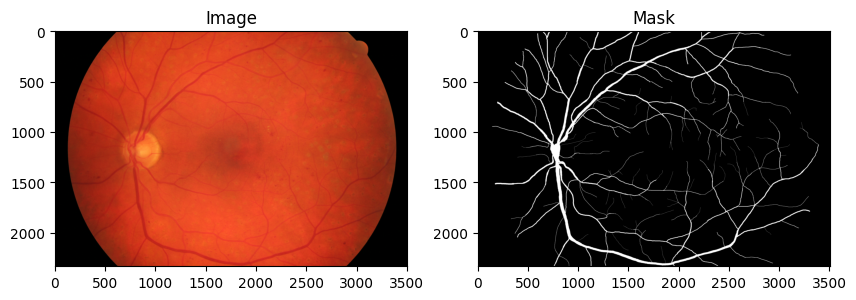

In [35]:
import matplotlib.pyplot as plt

sample_name = "hrf_01_dr.png"

img = cv2.imread(os.path.join(MERGED_IMG_DIR, sample_name))
mask = cv2.imread(os.path.join(MERGED_MASK_DIR, sample_name), 0)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Image")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")

plt.show()

# Resize all images to standard size

In [36]:
TARGET_SIZE = (512, 512)

for filename in tqdm(os.listdir(MERGED_IMG_DIR)):
    
    img_path = os.path.join(MERGED_IMG_DIR, filename)
    mask_path = os.path.join(MERGED_MASK_DIR, filename)
    
    image = cv2.imread(img_path)
    mask = cv2.imread(mask_path, 0)
    
    image_resized = cv2.resize(image, TARGET_SIZE)
    mask_resized = cv2.resize(mask, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
    
    cv2.imwrite(img_path, image_resized)
    cv2.imwrite(mask_path, mask_resized)

print("Resizing complete!")

100%|██████████| 113/113 [00:06<00:00, 16.19it/s]

Resizing complete!


# Converting hrf masks to binary

In [37]:
for filename in tqdm(os.listdir(MERGED_MASK_DIR)):
    
    mask_path = os.path.join(MERGED_MASK_DIR, filename)
    mask = cv2.imread(mask_path, 0)
    
    # Convert to binary
    mask = (mask > 127).astype(np.uint8) * 255
    
    cv2.imwrite(mask_path, mask)

print("Masks binarized!")

100%|██████████| 113/113 [00:00<00:00, 690.39it/s]

Masks binarized!
